In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from func_tools import normalize, get_labels, cnn_data_reshaping, reshape_lob_levels, plot_labels, label_insights, back_to_labels, get_pnl

import plotly_express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict tf to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
tf.test.gpu_device_name()

''

## Inputs

In [3]:
model_name = 'dynz_score_lob_v3_10s.h5'
security = 'USDT_BTC'
root_caching_folder = "Processed_Data"
#frequency = timedelta(seconds=10)
norm_type = 'dyn_z_score'
lob_depth = 10
trading_fee=0.000712

# labelling inputs
k_plus = 30#60
k_minus = 30#60
alpha = 0.001#0.0005
roll = 6 * 60 * 24 * 5 # 6 snap to get to 1 min * minutes * hours * days
print(f'Roll: {roll}')

Roll: 43200


## Data loading and predictions
- Import normalized data (cached)
- Get labels generated by our methodology (what we use for train and test)

- Load model saved
- Generate predictions from normalized reshaped data - predicted labels

- Import original data for assessing performance

In [4]:
#Import normalized data
test_dyn_df = pd.read_csv(f'{root_caching_folder}/{security}/TEST-{lob_depth}-{norm_type}-{roll}.csv', index_col=0) #norm bid-ask px and size

# Get original labels
test_depth_dyn, test_dt_index_dyn = reshape_lob_levels(test_dyn_df, output_type='array') # 1 test dataset reshaped for model eval
mid_px_test_dyn = pd.Series((test_depth_dyn[:,2] + test_depth_dyn[:,0]) / 2) # 2 mid px from top level ob
original_labels = get_labels(mid_px_test_dyn, k_plus, k_minus, alpha, long_only=False) # 3 labels from mid px
encoded_test_labels = np_utils.to_categorical(original_labels.values,3) # 4 test labels one hot encoded for eval#

label_insights(original_labels)

Depth Values shape: (430328, 40)
Datetime Index shape: (430328,)
Labels shape: (430328,)
Labels: [-1  0  1] 
Count: [212514   8744 209070] 
Pctg: [0.49384191 0.02031938 0.48583871]
Number of total transaction: 13530


13530

In [5]:
# Load the previously saved weights and evaluate model performance
deep_lob_loaded = tf.keras.models.load_model(model_name)
generator_test = TimeseriesGenerator(
    test_depth_dyn,
    encoded_test_labels,
    100,
    batch_size=64,
    shuffle=False
)

def evaluate_model(model):
    # Re-evaluate the model
    loss, acc = model.evaluate(generator_test, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100*acc))

#evaluate_model(deep_lob_loaded, test_depth_dyn, encoded_test_labels)

In [7]:
# Get predicted labels
predictions_prob = deep_lob_loaded.predict(generator_test, verbose=1)
map_labels = np.vectorize(back_to_labels) # vectorize back to labels from func_tools
predicted_labels = pd.Series(map_labels(np.argmax(predictions_prob,axis=1)), name='predicted_labels') # back to original 1,0,-1

label_insights(predicted_labels)

6723/6723 [==============================] - 115s 17ms/step
Labels shape: (430228,)
Labels: [-1  1] 
Count: [215092 215136] 
Pctg: [0.49994886 0.50005114]
Number of total transaction: 39421


39421

In [11]:
# Import original data
data = pd.read_csv(f'{root_caching_folder}/{security}/data-cache-10s.csv', index_col=0)
#lob_depth = data['Level'].max() + 1
train_test_split = int((data.shape[0] / lob_depth) * 0.7) # slice reference for train and test
test_timestamps = data['Datetime'].unique()[train_test_split:] # timestamps array
test_cached_data = data[data['Datetime'].isin(test_timestamps)].set_index(['Datetime', 'Level']) # split

In [12]:
# get pnl from normalized labels and real px timeseries (alway postive prices)
roll_shift = roll+1 # rolling period for dyn z score - + 1 from shift in ft.normalize
top_ob = test_cached_data[test_cached_data.index.get_level_values(1)==0][roll_shift:]
top_ob['Mid_Price'] = (top_ob['Ask_Price'] + top_ob['Bid_Price']) / 2
top_ob['Spread'] = (top_ob['Ask_Price'] - top_ob['Bid_Price']) / top_ob['Mid_Price']
top_ob['merge_index'] = top_ob.reset_index().index.values # useful for merging later
mid_px = top_ob.reset_index()['Mid_Price']


## Preparing data for backtesting

In [13]:
#idx_simulated_shifted = np.concatenate((0, idx_simulated[1:], np.array([df_simulated.shape[0]])))
def get_all_trades_performance(df_pnl, idx_pnl, trading_fee):
    '''Generate a dataframe with one row for each trade with all relevant information to assess a strategy

    Arguments:
    df_pnl -- pandas dataframe with mid, bid and ask prices info
    idx_pnl -- numpy array with indices of when trades occur
    trading_fee -- float indicating fixed transaction cost (exchange determined)
    '''

    start_idx = np.concatenate((np.array([0]), idx_pnl))
    end_idx = np.concatenate((idx_pnl, np.array([df_pnl.shape[0]])))
    trades = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) # initiate an array with n values - number of columns

    def calculate_return(start_px, end_px, trade_type, trading_fee):
        if trade_type == 1:
            pctg_chg = (((end_px - (end_px*trading_fee)) - (start_px+(start_px*trading_fee)))/(start_px)) * trade_type # buy trade
        elif trade_type == -1:
            pctg_chg = (((end_px + (end_px*trading_fee)) - (start_px-(start_px*trading_fee)))/(start_px)) * trade_type # sell trade
        else:
            pctg_chg = 0 # neutral

        return pctg_chg

    # loop through each trade
    for start_trade, end_trade in zip(start_idx, end_idx):

        try:
            
            df = df_pnl[start_trade:end_trade] # slice of with single trade
            df_exit_slippage = df_pnl[end_trade+1:end_trade+3]

            trade_type = df['labels'].values[0] # direction from first label

            start_mid_px = df['Mid_Price'].values[0]
            end_mid_px = df['Mid_Price'].values[-1] 

            start_ask_px = df['Ask_Price'].values[0]
            end_ask_px = df['Ask_Price'].values[-1]

            start_bid_px = df['Bid_Price'].values[0]
            end_bid_px = df['Bid_Price'].values[-1]

            if df.shape[0] == 1:
                start_mid_px_slip = df_exit_slippage['Mid_Price'].values[0]
                start_ask_px_slip = df_exit_slippage['Ask_Price'].values[0]
                start_bid_px_slip = df_exit_slippage['Bid_Price'].values[0]

            else:
                start_mid_px_slip = df['Mid_Price'].values[1]
                start_ask_px_slip = df['Ask_Price'].values[1]
                start_bid_px_slip = df['Bid_Price'].values[1]

            end_mid_px_slip_1 = df_exit_slippage['Mid_Price'].values[0] # px at which trade is closed is when new signal is generated
            end_mid_px_slip_2 = df_exit_slippage['Mid_Price'].values[1] # or somewhere between that and the next timestep - time to generate order

            end_ask_px_slip_1 = df_exit_slippage['Ask_Price'].values[0]
            end_ask_px_slip_2 = df_exit_slippage['Ask_Price'].values[1]

            end_bid_px_slip_1 = df_exit_slippage['Bid_Price'].values[0]
            end_bid_px_slip_2 = df_exit_slippage['Bid_Price'].values[1]

            gross_trade_return = calculate_return(start_mid_px, end_mid_px, trade_type, 0) # gross performance
            
            fees_impact = gross_trade_return - calculate_return(start_mid_px, end_mid_px, trade_type, trading_fee) # net trading fee performance (entry and exit)

            slippage_impact = gross_trade_return - calculate_return((start_mid_px + start_mid_px_slip)/2, (end_mid_px_slip_1 + end_mid_px_slip_2)/2, trade_type, 0) # gross minus slippage only using mid

            if trade_type == 1:
                spread_impact = gross_trade_return - calculate_return((start_ask_px + start_ask_px_slip)/2, (end_bid_px_slip_1 + end_bid_px_slip_2)/2, trade_type, 0) - (slippage_impact) # net of bbo spread performance (round-trip)
                net_return = calculate_return((start_ask_px + start_ask_px_slip)/2, (end_bid_px_slip_1 + end_bid_px_slip_2)/2, trade_type, trading_fee) # net return all-in
            elif trade_type == -1:
                spread_impact = gross_trade_return - calculate_return((start_bid_px + start_bid_px_slip)/2, (end_ask_px_slip_1 + end_ask_px_slip_2)/2, trade_type, 0) - (slippage_impact)# net of bbo spread performance (round-trip)
                net_return = calculate_return((start_bid_px + start_bid_px_slip)/2, (end_ask_px_slip_1 + end_ask_px_slip_2)/2, trade_type, trading_fee) # net return all-in
            elif trade_type == 0:
                spread_impact = gross_trade_return # 0
                net_return = gross_trade_return # 0

            mid_px_std = (np.log(df['Mid_Price']) - np.log(df['Mid_Price'].shift(1))).std()
            sharpe_ratio = net_return / mid_px_std # std of log gross returns - would be better with net, but this is a fair approx

            array_to_append = np.array([start_trade, 
                                        end_trade, 
                                        start_mid_px, 
                                        start_mid_px_slip, 
                                        end_mid_px,
                                        end_mid_px_slip_1,
                                        end_mid_px_slip_2,
                                        start_ask_px, 
                                        start_ask_px_slip, 
                                        end_ask_px,
                                        end_ask_px_slip_1,
                                        end_ask_px_slip_2,
                                        start_bid_px, 
                                        start_bid_px_slip, 
                                        end_bid_px,
                                        end_bid_px_slip_1,
                                        end_bid_px_slip_2,
                                        trade_type, 
                                        gross_trade_return, 
                                        fees_impact, 
                                        spread_impact, 
                                        slippage_impact, 
                                        net_return,
                                        mid_px_std,
                                        sharpe_ratio])
                                        
            trades = np.vstack([trades, array_to_append])

        except Exception as e:
            print(f'{e} at start_idx = {start_trade} and end_idx = {end_trade}. Shape dataframe = {df_pnl.shape[0]}')
            exc_type, exc_obj, exc_tb = sys.exc_info() # select cell and press ctrl+L to show rows in jupyter notebook
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(f'Error details: {exc_type}, {fname}, {exc_tb.tb_lineno}')
            array_to_append = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
            trades = np.vstack([trades, array_to_append])
            continue
    df_trades_all = pd.DataFrame(trades, 
                                columns=[
                                    'start_trade', 
                                    'end_trade', 
                                    'start_mid_px',
                                    'start_mid_px_slip', 
                                    'end_mid_px',
                                    'end_mid_px_slip_1',
                                    'end_mid_px_slip_2',
                                    'start_ask_px', 
                                    'start_ask_px_slip', 
                                    'end_ask_px',
                                    'end_ask_px_slip_1',
                                    'end_ask_px_slip_2',
                                    'start_bid_px', 
                                    'start_bid_px_slip',
                                    'end_bid_px',
                                    'end_bid_px_slip_1',
                                    'end_bid_px_slip_2',
                                    'direction', 
                                    'gross_trade_return', 
                                    'fees_impact', 
                                    'spread_impact', 
                                    'slippage_impact', 
                                    'net_return',
                                    'mid_px_std',
                                    'sharpe_ratio'
                                    ])
    df_trades_all['trade_length'] = df_trades_all['end_trade'] - df_trades_all['start_trade'] # how many periods a trade lasts
    df_trades_all['winning_net_trades'] = df_trades_all.apply(lambda x: 1 if x['net_return']>0 else (-1 if x['net_return']<0 else 0), axis=1) # flag for winning trades
    
    return df_trades_all[(df_trades_all == 0).sum(axis=1) != df_trades_all.shape[1]] # remove rows full of zeros   

In [14]:
def get_df_all_trades(df_pnl, idx_pnl, trading_fee):
    df_trades_all = get_all_trades_performance(df_pnl, idx_pnl, trading_fee)

    # trades without "zeros" - used to calculate stats
    df_trades_in = df_trades_all[df_trades_all['direction'] != 0]
    # assign a timestamp to start trade. Quicker than doing it in the loop:
    df_trades_in = pd.merge(df_trades_in, top_ob.reset_index()[['merge_index', 'Datetime']], how='left', left_on='start_trade', right_on='merge_index')
    df_trades_in['Datetime'] = pd.to_datetime(df_trades_in['Datetime'])

    return df_trades_all, df_trades_in

In [15]:
# Generate trade performance dataframe for original labels
pnl_simulated, df_simulated, idx_simulated = get_pnl(mid_px, original_labels, trading_fee=0.000712)
df_simulated = pd.merge(df_simulated, top_ob.reset_index(), left_index=True, right_index=True) # merge with top ob to get mid, bid and ask

In [16]:
# Generate trade performance dataframe for predicted labels
# need check here on dataframes shapes. Or better, merge by datetime rather thank a number, less error prone
pnl_predicted, df_predicted, idx_predicted = get_pnl(mid_px, predicted_labels, trading_fee=0.000712)
df_predicted = pd.merge(df_predicted, top_ob[100:].reset_index(), left_index=True, right_index=True) # merge with top ob to get mid, bid and ask - lag top_ob by 100 timesteps

In [17]:
#df_trades_all, df_trades_in = get_df_all_trades(df_simulated, idx_simulated, trading_fee)
df_trades_all, df_trades_in = get_df_all_trades(df_predicted, idx_predicted, trading_fee)

index 0 is out of bounds for axis 0 with size 0 at start_idx = 0 and end_idx = 0. Shape dataframe = 430228
Error details: <class 'IndexError'>, <ipython-input-13-103a49a4135f>, 33
index 1 is out of bounds for axis 0 with size 1 at start_idx = 430218 and end_idx = 430226. Shape dataframe = 430228
Error details: <class 'IndexError'>, <ipython-input-13-103a49a4135f>, 55
index 0 is out of bounds for axis 0 with size 0 at start_idx = 430226 and end_idx = 430227. Shape dataframe = 430228
Error details: <class 'IndexError'>, <ipython-input-13-103a49a4135f>, 45
index 0 is out of bounds for axis 0 with size 0 at start_idx = 430227 and end_idx = 430228. Shape dataframe = 430228
Error details: <class 'IndexError'>, <ipython-input-13-103a49a4135f>, 45


In [ ]:
df_trades_all_original, df_trades_in_original = get_df_all_trades(df_simulated, idx_simulated, trading_fee)

In [ ]:
#df_trades_in[0:5].T

In [ ]:
#px.line(y=daily_std)

In [ ]:
#px.line(y=daily_returns)

In [ ]:
# # mid px linechart - sampled
# hourly_mid_line = go.Figure()
# hourly_mid_line.add_trace(go.Scatter(y=mid_px.iloc[::6*60*24].values, name='mid'))

# hourly_mid_line.update_layout(title='<b>Daily sampled mid</b>')
# hourly_mid_line.show()

## Label comparison

In [160]:
k_plus = 30#60
k_minus = 30#60
alpha = 0.0005#0.0005
m_minus = mid_px_test_dyn.rolling(k_minus).mean() # mean prev k prices
m_plus = mid_px_test_dyn.shift(-k_plus).rolling(k_plus).mean() # # mean next k prices

In [161]:
direction_pos = (m_plus - m_minus) / m_minus
direction_neg = (m_minus - m_plus) / m_plus
direction = pd.Series(np.where(mid_px_test_dyn>=0, direction_pos, direction_neg)) # flip when ts is neg

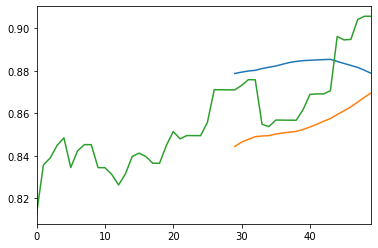

In [162]:
m_plus[:50].plot()
m_minus[:50].plot()
mid_px_test_dyn[:50].plot()
# pd.Series(np.where(direction>alpha, 1, 
#            np.where(direction<-alpha, -1, 0)), index=direction.index, name='labels')[:50].plot() 

In [163]:
labels = pd.Series(np.where(direction>alpha, 1, 
            np.where(direction<-alpha, -1, 0)), index=direction.index, name='labels')
px_ts = top_ob.reset_index()[['Mid_Price']]
pnl, df, idx = get_pnl(px_ts, labels, trading_fee=0.000712)# labels and label change index

In [165]:
df['pctg_chg'] = df['px'].pct_change()
df['log_ret'] = np.log(df['px']) - np.log(df['px'].shift(1))
df['individual_return'] = df['log_ret'] * df['labels']# need to add +1 to multiply with tr fee
df['trading_fees'] = df.apply(lambda x: 1-0.000712 if x['trade_flag'] else 1, axis=1)

In [166]:
#df['individual_returns'] = ((df['labels'] * df['return'] * df['trading_fees'])) # correctly assign trading fee. previous approach of multiplying did not work
#example: 0.999288 * a 1bps gain, would still be positive. Subtracting would be better

In [167]:
df['trade_grouper'] = np.nan
df['trade_grouper'].loc[idx] = idx
df['trade_grouper'] = df['trade_grouper'].fillna(method='ffill')

In [168]:
df

,px,labels,return,realized_return,trade_flag,pnl,pctg_chg,log_ret,individual_return,trading_fees,trade_grouper
0,11799.439763,0,NaN,NaN,False,NaN,NaN,NaN,NaN,1.0,NaN
1,11803.793449,0,0.000369,0.0,False,1.000000e+00,0.000369,0.000369,0.0,1.0,NaN
2,11804.425125,0,0.000054,0.0,False,1.000000e+00,0.000054,0.000054,0.0,1.0,NaN
3,11805.533132,0,0.000094,0.0,False,1.000000e+00,0.000094,0.000094,0.0,1.0,NaN
4,11806.214667,0,0.000058,0.0,False,1.000000e+00,0.000058,0.000058,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
430323,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0
430324,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0
430325,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0
430326,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0


In [171]:
trade_gross_profit - 0.0015

trade_grouper
29.0       -0.001262
53.0       -0.001500
54.0        0.000359
133.0      -0.000028
156.0      -0.000441
              ...   
430154.0   -0.000840
430215.0   -0.001500
430218.0   -0.000892
430280.0   -0.001098
430298.0   -0.001500
Name: individual_return, Length: 11785, dtype: float64

In [183]:
df

,px,labels,return,realized_return,trade_flag,pnl,pctg_chg,log_ret,individual_return,trading_fees,trade_grouper
0,11799.439763,0,NaN,NaN,False,NaN,NaN,NaN,NaN,1.0,NaN
1,11803.793449,0,0.000369,0.0,False,1.000000e+00,0.000369,0.000369,0.0,1.0,NaN
2,11804.425125,0,0.000054,0.0,False,1.000000e+00,0.000054,0.000054,0.0,1.0,NaN
3,11805.533132,0,0.000094,0.0,False,1.000000e+00,0.000094,0.000094,0.0,1.0,NaN
4,11806.214667,0,0.000058,0.0,False,1.000000e+00,0.000058,0.000058,0.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
430323,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0
430324,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0
430325,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0
430326,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0


In [180]:
trade_gross_profit = df.groupby('trade_grouper')['individual_return'].sum() - 0.0020
positive_trades = trade_gross_profit[trade_gross_profit>0]
print(positive_trades.shape[0])
px.histogram(positive_trades)

2528


In [185]:
# merge initial df with the code of positive trades.. replace NAs with 0, and that's the clened labelsdf_trades_all
# wrap in a new get label function to allow iteration within an optimizer
pd.merge(df, positive_trades, left_on='trade_grouper', right_index=True, how='outer')

,px,labels,return,realized_return,trade_flag,pnl,pctg_chg,log_ret,individual_return_x,trading_fees,trade_grouper,individual_return_y
0,11799.439763,0,NaN,NaN,False,NaN,NaN,NaN,NaN,1.0,NaN,NaN
1,11803.793449,0,0.000369,0.0,False,1.000000e+00,0.000369,0.000369,0.0,1.0,NaN,NaN
2,11804.425125,0,0.000054,0.0,False,1.000000e+00,0.000054,0.000054,0.0,1.0,NaN,NaN
3,11805.533132,0,0.000094,0.0,False,1.000000e+00,0.000094,0.000094,0.0,1.0,NaN,NaN
4,11806.214667,0,0.000058,0.0,False,1.000000e+00,0.000058,0.000058,0.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
430323,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0,NaN
430324,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0,NaN
430325,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0,NaN
430326,10535.661275,0,0.000000,0.0,False,3.630201e+06,0.000000,0.000000,0.0,1.0,430298.0,NaN


In [ ]:
def get_labels(ts, k_plus, k_minus, alpha, long_only=True):
    '''
    Function to label timeseries - buy, sell, nothing

    Arguments:
    ts -- pandas series or array
    k_plus -- integer, prediction horizon (how much forward am I looking to get price direction)
    k_minus -- integer, prediction horizon (how much backward am I looking to get price direction)
    alpha -- float, threshold for applying labels
    long_only -- boolean that to turn off/on profits from short-selling

    Returns: pandas series
    '''

    m_minus = ts.rolling(k_minus).mean() # mean prev k prices
    m_plus = ts.shift(-k_plus).rolling(k_plus).mean() # # mean next k prices

    # direction of price movements at time t
    #direction = (m_plus - m_minus) / m_minus

    direction_pos = (m_plus - m_minus) / m_minus
    direction_neg = (m_minus - m_plus) / m_plus
    direction = pd.Series(np.where(ts>=0, direction_pos, direction_neg)) # flip when ts is neg

    if long_only:
        # assign labels based on alpha threshold
        return pd.Series(np.where(direction>alpha, 1, 0), index=direction.index, name='labels')
    
    else:
        # assign labels based on alpha threshold
        return pd.Series(np.where(direction>alpha, 1, 
            np.where(direction<-alpha, -1, 0)), index=direction.index, name='labels')    

In [ ]:
#top_ob[429005:429040][['Ask_Price', 'Bid_Price', 'Mid_Price']].plot()
# check what happens here below level 1

In [ ]:
#top_ob[429005:429040][['Ask_Size', 'Bid_Size']].plot()

In [ ]:
predictions_prob.shape

In [ ]:
top_ob.shape, mid_px_test_dyn.shape

In [ ]:
#np.vectorize(back_to_labels) # vectorize back to labels from func_tools
#pd.Series(map_labels(np.argmax(predictions_prob[slice_start:slice_end],axis=1)), name='predicted_labels').plot() # back to original 1,0,-1

In [ ]:
# exec_chart.add_trace(go.Scatter(y=long_start['start_px_long'], x=long_start['start_trade'], mode='markers', marker_size=5, name='long entry')) # set color and size
# exec_chart.add_trace(go.Scatter(y=long_end['end_px_long'], x=long_end['end_trade'], mode='markers', marker_size=5, name='long exit'))

In [ ]:
top_ob['Mid_Price'][slice_start+pred_timesteps:slice_end+pred_timesteps]

In [ ]:

# plot predicted labels, real labels, difference between the two and probability of a "buy" label
label_comp = make_subplots(rows=1, cols=1,specs=[[{"secondary_y": True}]])

label_comp.update_layout(title=f'<b>Label Comparison</b>', title_x=0.5)

label_comp.add_trace(go.Scatter(y=predicted_labels[slice_start:slice_end]+5, name='predicted'))
label_comp.add_trace(go.Scatter(y=original_labels[pred_timesteps:][slice_start:slice_end].values-5, name='labels'))
label_comp.add_trace(go.Scatter(y=predicted_labels[slice_start:slice_end] - original_labels[pred_timesteps:][slice_start:slice_end].values, name='predictions - labels'))

label_comp.add_trace(go.Scatter(y=predictions_prob[:,1][slice_start:slice_end], name = 'Probability of 1'), secondary_y=True)

label_comp.update_layout(width=1400, height=600) # plot labels background

## Strategy Overview

In [ ]:
# Filters
trades_in_filtered = df_trades_in[(df_trades_in['trade_length'] >= 50) & (df_trades_in['direction'].isin([1.0, -1.0]))]
print(f'{trades_in_filtered.shape[0]} trades filtered out of {df_trades_in.shape[0]} total trades')

In [ ]:
pred_timesteps = 100
trade_id = 46
slice_start = int(trades_in_filtered[trades_in_filtered.index==46]['start_trade'])
slice_end = int(trades_in_filtered[trades_in_filtered.index==187]['end_trade'])#3877#int(trades_in_filtered.iloc[trade_id]['end_trade'])
trades_in_plotting = trades_in_filtered[(trades_in_filtered.index>=46)&(trades_in_filtered.index<=187)]
# filter with slice start and end the trades_in_filtered

#Single trades chart -largest chart
long_start = trades_in_plotting[trades_in_plotting['direction']==1][['start_trade', 'start_ask_px', 'start_ask_px_slip']]
long_start['start_px_long'] = (long_start['start_ask_px'] + long_start['start_ask_px_slip'])/2

long_end = trades_in_plotting[trades_in_plotting['direction']==1][['end_trade', 'end_bid_px_slip_1', 'end_bid_px_slip_2']]
long_end['end_px_long'] = (long_end['end_bid_px_slip_1'] + long_end['end_bid_px_slip_2'])/2

short_start = trades_in_plotting[trades_in_plotting['direction']==-1][['start_trade', 'start_bid_px', 'start_bid_px_slip']]
short_start['start_px_short'] = (short_start['start_bid_px'] + short_start['start_bid_px_slip'])/2

short_end = trades_in_plotting[trades_in_plotting['direction']==-1][['end_trade', 'end_ask_px_slip_1', 'end_ask_px_slip_2']]
short_end['end_px_short'] = (short_end['end_ask_px_slip_1'] + short_end['end_ask_px_slip_2'])/2


pred_prob_fig = make_subplots(rows=3, cols=1, specs=[[{"secondary_y": False}], [{"secondary_y": False}], [{"secondary_y": False}]],
    subplot_titles=("Prediction Probability", ""), shared_xaxes=True, row_heights=[0.4, 0.3, 0.3], vertical_spacing = 0.0)

plot_idx = np.arange(slice_start, slice_end)
pred_prob_fig.add_trace(go.Scatter(y=predictions_prob[:,1][slice_start:slice_end], x=plot_idx, name = 'Prob of long'), secondary_y=False)
pred_prob_fig.add_trace(go.Scatter(y=predictions_prob[:,2][slice_start:slice_end], x=plot_idx, name = 'Prob of short'), secondary_y=False)
pred_prob_fig.add_trace(go.Scatter(y=top_ob['Mid_Price'][slice_start+pred_timesteps:slice_end+pred_timesteps], x=plot_idx, name = 'Mid Px'), row=2, col=1, secondary_y=False)
pred_prob_fig.add_trace(go.Scatter(y=mid_px_test_dyn[slice_start+pred_timesteps:slice_end+pred_timesteps], x=plot_idx, name = 'Norm Mid Px'), row=3, col=1, secondary_y=False)

#plot long trade prices
pred_prob_fig.add_trace(go.Scatter(y=long_start['start_px_long'], x=long_start['start_trade'], mode='markers', marker_size=5, name='long entry'), row=2, col=1) # set color and size
pred_prob_fig.add_trace(go.Scatter(y=long_end['end_px_long'], x=long_end['end_trade'], mode='markers', marker_size=5, name='long exit', marker=dict(color='Navy')), row=2, col=1)

# plot short trade prices
pred_prob_fig.add_trace(go.Scatter(y=short_start['start_px_short'], x=short_start['start_trade'], mode='markers', marker_size=5, name='short entry'), row=2, col=1) # set color and size
pred_prob_fig.add_trace(go.Scatter(y=short_end['end_px_short'], x=short_end['end_trade'], mode='markers', marker_size=5, name='short exit'), row=2, col=1)

pred_prob_fig.update_layout(width=1400, height=900) 
pred_prob_fig.show()

In [ ]:
# agg daily stats - to verify
daily_returns = trades_in_filtered.groupby([trades_in_filtered['Datetime'].dt.floor('D')])['net_return'].sum()
df_trades_in['dailized_std'] = trades_in_filtered['mid_px_std'] * np.sqrt(trades_in_filtered['trade_length'] / (6*60*24))
daily_std = trades_in_filtered.groupby([trades_in_filtered['Datetime'].dt.floor('D')])['dailized_std'].sum()
daily_sharpe = daily_returns / daily_std
#daily_sharpe

In [ ]:
# get backtesting notional values associated with the strategy
cumulative_no = ((trades_in_filtered['net_return']+1) * 1000 - 1000).cumsum() + 1000
compound_no = (trades_in_filtered['net_return']+1).cumprod() * 1000

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=trades_in_filtered['start_trade'], y=cumulative_no, name='cumulative notional'), secondary_y=False)
fig.add_trace(go.Scatter(x=trades_in_filtered['start_trade'], y=compound_no, name='compound notional'), secondary_y=False)
fig.add_trace(go.Scatter(x=trades_in_filtered['start_trade'], y=trades_in_filtered['start_mid_px'], name='mid price'), secondary_y=True)
fig.update_layout(title='<b>Notional value</b>')
fig.update_yaxes(title_text='<b>USD</b>', secondary_y=False)
fig.update_yaxes(title_text='Currency', secondary_y=True)
fig.show()

cumulative_no.iloc[-1], compound_no.iloc[-1]

In [ ]:
df_grouped_count = trades_in_filtered.groupby([pd.Grouper(freq='1d', key='Datetime'), 'direction'])['start_trade'].count().reset_index()
trades_over_time = px.bar(df_grouped_count, x='Datetime', y='start_trade', color=df_grouped_count['direction'].astype('str'), title="<b>Number of trades over time</b>")
trades_over_time.show()

In [ ]:
trades_in_filtered[trades_in_filtered['direction']==1][['start_trade', 'end_trade', 'direction', 'start_ask_px', 'start_ask_px_slip']]
def define_prices(x):
    if

long_start['start_px_long'] = (long_start['start_ask_px'] + long_start['start_ask_px_slip'])/2

In [ ]:
#Single trades chart -largest chart
long_start = trades_in_filtered[trades_in_filtered['direction']==1][['start_trade', 'start_ask_px', 'start_ask_px_slip']]
long_start['start_px_long'] = (long_start['start_ask_px'] + long_start['start_ask_px_slip'])/2

long_end = trades_in_filtered[trades_in_filtered['direction']==1][['end_trade', 'end_bid_px_slip_1', 'end_bid_px_slip_2']]
long_end['end_px_long'] = (long_end['end_bid_px_slip_1'] + long_end['end_bid_px_slip_2'])/2

short_start = trades_in_filtered[trades_in_filtered['direction']==-1][['start_trade', 'start_bid_px', 'start_bid_px_slip']]
short_start['start_px_short'] = (short_start['start_bid_px'] + short_start['start_bid_px_slip'])/2

short_end = trades_in_filtered[trades_in_filtered['direction']==-1][['end_trade', 'end_ask_px_slip_1', 'end_ask_px_slip_2']]
short_end['end_px_short'] = (short_end['end_ask_px_slip_1'] + short_end['end_ask_px_slip_2'])/2


# exec_chart = px.line(title='<b>Linechart</b>', width=1200, height=600)
# exec_chart.add_trace(go.Scatter(y=top_ob['Mid_Price'], x=top_ob.reset_index().index.values, name='mid')) # date: x=top_ob.index.get_level_values(0)
# exec_chart.add_trace(go.Scatter(y=long_start['start_px_long'], x=long_start['start_trade'], mode='markers', marker_size=5, name='long entry')) # set color and size
# exec_chart.add_trace(go.Scatter(y=long_end['end_px_long'], x=long_end['end_trade'], mode='markers', marker_size=5, name='long exit'))

# exec_chart.show()

In [ ]:
trades_in_filtered.columns

In [ ]:
# Plot net return distribution
trades = [trades_in_filtered['net_return'].values]
labels = ['Trades']
fig = ff.create_distplot(trades, labels, bin_size = 0.0001)
# Add shapes
avg = np.mean(trades)
stdev = np.std(trades)

fig.add_shape(type="line", yref='paper',
    x0=avg, y0=0, x1=avg, y1=1,
    line=dict(color="RoyalBlue",width=2)
)

fig.add_shape(type="line", yref='paper',
    x0=avg+stdev, y0=0, x1=avg+stdev, y1=1,
    line=dict(color="RoyalBlue",width=2, dash="dot")
)

fig.add_shape(type="line", yref='paper',
    x0=avg-stdev, y0=0, x1=avg-stdev, y1=1,
    line=dict(color="RoyalBlue",width=2, dash="dot")
)

fig.add_shape(type="line", yref='paper',
    x0=0, y0=0, x1=0, y1=1,
    line=dict(color="Black",width=2, dash="dashdot")
)


fig.update_layout(title="<b>Trades distribution - net return</b>", width=1200, height=600, xaxis=dict(tickformat=',.3%'))
fig.show()

In [ ]:
# Plot trade lengths
max_trade_length = int(trades_in_filtered['trade_length'].max())
hist_trade_length = px.histogram(trades_in_filtered, x='trade_length', color='direction', title='<b>Trade length</b>')
avg = trades_in_filtered['trade_length'].mean() # average trade length
hist_trade_length.add_shape(type="line", yref='paper',
    x0=avg, y0=0, x1=avg, y1=1,
    line=dict(color="Black",width=2, dash="dashdot")
)
hist_trade_length.show()

# Plot net returns (by length and individual trades)
hist_ret_len = px.histogram(trades_in_filtered, x='trade_length', y='net_return', histfunc='avg', color='direction', nbins=max_trade_length, title='<b>Net Return by trade length</b>')
hist_ret_len.update_layout(yaxis=dict(tickformat=',.3%'))
hist_ret_len.show()

avg_net_by_length = trades_in_filtered.groupby('trade_length')['net_return'].mean()
ret_len_scatter = px.scatter(trades_in_filtered, x='trade_length', y='net_return', color=trades_in_filtered['direction'].astype('str'), opacity=0.3, title='<b>Net return single trades</b>')
ret_len_scatter.add_trace(go.Scatter(x=avg_net_by_length.index, y=avg_net_by_length.values, mode='lines', name='Average'))
ret_len_scatter.update_layout(yaxis=dict(tickformat=',.3%'))
ret_len_scatter.show()

# Plot gross returns (by length and individual trades)
hist_gret_len = px.histogram(trades_in_filtered, x='trade_length', y='gross_trade_return', histfunc='avg', color='direction', nbins=max_trade_length,title='<b>Gross return by trade length</b>')
hist_gret_len.update_layout(yaxis=dict(tickformat=',.3%'))
hist_gret_len.show()

gret_len_scatter = px.scatter(trades_in_filtered, x='trade_length', y='gross_trade_return', color=trades_in_filtered['direction'].astype('str'), title='<b>Gross return single trades</b>')
gret_len_scatter.update_layout(yaxis=dict(tickformat=',.3%'))
gret_len_scatter.show()

#fig.update_layout(barmode='overlay')

In [ ]:
# Percentage of winning trades
pctg_winning_trades = trades_in_filtered[trades_in_filtered['winning_net_trades']==1]['winning_net_trades'].sum() / trades_in_filtered.shape[0]

winning_df = trades_in_filtered[trades_in_filtered['net_return']>0]
losing_df = trades_in_filtered[trades_in_filtered['net_return']<0]

# Average winning trade return
avg_ret_winning = winning_df['net_return'].mean()
w_avg_ret_winning = np.average(winning_df['net_return'], weights=winning_df['trade_length'])

# Average losing trade return
avg_ret_losing = losing_df['net_return'].mean()
w_avg_ret_losing = np.average(losing_df['net_return'], weights=losing_df['trade_length'])

avg_ret_all = trades_in_filtered['net_return'].mean()
avg_gross_all = trades_in_filtered['gross_trade_return'].mean()
pctg_winning_trades, avg_ret_winning, avg_ret_losing, avg_ret_all, avg_gross_all

## Timeseries Description

In [ ]:
top_ob['log_rets'] = (np.log(top_ob['Mid_Price']) - np.log(top_ob['Mid_Price'].shift(1))) # assumes variable is identivally distributed

# np.std(top_ob['log_rets'])
ten_s_std = np.sqrt(np.sum((top_ob['log_rets'] - top_ob['log_rets'].mean())**2)/(top_ob['log_rets'].shape[0]-1)) # -1 unbiased estimator
one_h_std = ten_s_std * np.sqrt(6*60) # assuming statistic independence of returns

In [ ]:
top_ob['hourly_datetime'] = pd.to_datetime(top_ob.index.get_level_values(0)).floor('H')
top_ob['daily_datetime'] = pd.to_datetime(top_ob.index.get_level_values(0)).floor('D')
top_ob['hour_of_day'] = pd.to_datetime(top_ob['hourly_datetime']).dt.hour
top_ob['minute_of_day'] = pd.to_datetime(top_ob.index.get_level_values(0)).minute
hourly_returns = top_ob.groupby(['hourly_datetime'])['log_rets'].sum() # assumption that log (continuous) returns are additive
daily_returns = top_ob.groupby(['daily_datetime'])['log_rets'].sum() # assumption that log (continuous) returns are additive

px.histogram(hourly_returns, title='<b>Hourly Log Returns</b>')

In [ ]:
hourly_std = top_ob.groupby(['hourly_datetime'])['log_rets'].std() 
daily_std = top_ob.groupby(['daily_datetime'])['log_rets'].std()
hour_of_day_std = top_ob.groupby(['hour_of_day'])['log_rets'].std() 
minute_of_day_std = top_ob.groupby(['minute_of_day'])['log_rets'].std() 

In [ ]:
rr_scatter = px.scatter(top_ob, x=hourly_returns, y=hourly_std, title='<b>Risk - Return Scatter</b>')
rr_scatter.show()

std_over_time = px.histogram(top_ob, x=hourly_std.index, y=hourly_std, )
std_over_time.show()

std_hr_day = px.histogram(top_ob, x=hour_of_day_std.index, y=hour_of_day_std, nbins=24, title='<b>Std hour of the day</b>')
std_hr_day.update_layout(bargap=0.15)
std_hr_day.show()

std_min_day = px.histogram(top_ob, x=minute_of_day_std.index, y=minute_of_day_std, nbins=60, title='<b>Std minute of the hour</b>')
std_min_day.update_layout(bargap=0.15)
std_min_day.show()

In [ ]:
#px.line(y=top_ob['Mid_Price'])

In [ ]:
#px.line(y=top_ob['log_rets'].cumsum())

In [ ]:
#px.histogram(top_ob['log_rets'])

In [ ]:
trades_length_grouped = df_trades_all.groupby('direction').agg({'trade_length':['count','mean','sum']})
trades_length_grouped.columns = trades_length_grouped.columns.droplevel(0)
lsn_time_pie = px.pie(trades_length_grouped, values='sum', names=trades_length_grouped.index, title='<b>Long-Short-Neutral (time)</b>')
#lsn_time_pie.show()

lsn_numb_trades_sun = px.sunburst(df_trades_all, path=['direction', 'winning_net_trades'],values='trade_length', title='<b>Long-Short-Neutral (# of trades)</b>')
#lsn_numb_trades_sun.show()